In [1]:
import scanpy as sc
import scrublet as scr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [28]:
%matplotlib inline

In [30]:
sc.settings.verbosity = 3
sc.settings._vector_friendly = False

plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.family"] = ["Arial"]
plt.rcParams["font.sans-serif"] = ["Arial"]

In [3]:
DATA_DIR = Path("/projects/robson-lab/research/brain-stem_rtn/data")
OUTPUT_DIR = Path("/projects/robson-lab/research/brain-stem_rtn/analysis/neurons")
AGG_NAME = "neuronal_agg"

In [4]:
from datetime import datetime

def timestamp():
    return datetime.now().strftime("%Y-%m-%dT%H-%M-%S")

def save_adata(adata, suffix="", subdir=""):
    filename = f"{adata.uns['library_id']}{'-' + suffix if suffix else ''}-{timestamp()}.h5ad"
    sc.write(Path(adata.uns["output_dir"]) / subdir / filename, adata)

def load_raw_data(record):
    possible_input_paths = (DATA_DIR / "processed" / record.library_id).glob("outs/filtered*.h5")
    input_path = list(filter(lambda p: p.exists(), possible_input_paths))[0]
    input_dir = input_path.parent

    adata = sc.read_10x_h5(input_path, record.genome)
    adata.var_names_make_unique()

    adata.obs["sequencing_saturation"] = np.nan
    seqsat_file = input_dir / "sequencing_saturation.csv"
    if seqsat_file.exists():
        seqsat = pd.read_csv(seqsat_file, index_col=0, header=0)
        adata.obs.loc[seqsat.index, "sequencing_saturation"] = seqsat["saturation"].values

    for key, value in record.items():
        adata.uns[key] = value

    adata.uns["analyst"] = "Bill Flynn"
    adata.uns["analyst_email"] = "bill.flynn@jax.org"

    adata.uns["datetime_created"] = timestamp()

    output_dir = OUTPUT_DIR / "h5ad"
    adata.uns["input_file"] = str(input_path)
    adata.uns["input_dir"] = str(input_dir)
    adata.uns["output_dir"] = str(output_dir)

    hemo_genes = pd.read_csv(DATA_DIR / "databases" / "hemoglobin_genes.mm10.csv", header=None, index_col=1).index
    mito_genes = pd.read_csv(DATA_DIR / "databases" / "mito_genes.mm10.csv", header=None, index_col=1).index
    ribo_genes = adata.var_names.str.match("^(Mrp|Rp)[ls]")
    chrY_genes = pd.read_csv(DATA_DIR / "databases" / "mm10.chrY_genes.csv", index_col=1).index
    # adapted from https://academic.oup.com/jmcb/article/11/8/703/5188008#164389921
    # exclude genes with annotations "Other", "Function known but...", and "Uncharacterized"
    cc_genes = pd.read_csv(DATA_DIR / "databases" / "cell_cycle.csv", header=0, index_col=1).index[:484]
    sr_genes = pd.read_csv(DATA_DIR / "databases" / "coregene_stress-response.csv", header=0, index_col=6).index

    adata.var["mitochondrial"] = adata.var_names.isin(mito_genes)
    adata.var["hemoglobin"] = adata.var_names.isin(hemo_genes)
    adata.var["ribosomal"] = ribo_genes
    adata.var["cell_cycle"] = adata.var_names.isin(cc_genes.str.capitalize())
    adata.var["stress_response"] = adata.var_names.isin(sr_genes.str.capitalize())
    adata.var["sex_linked"] = adata.var_names.isin(chrY_genes.union(["Xist"]))

    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=("mitochondrial", "hemoglobin", "ribosomal", "cell_cycle", "stress_response", "sex_linked"),
        inplace=True
    )

    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata.obs["scrublet_putative_doublet"] = predicted_doublets
    adata.obs["scrublet_score"] = doublet_scores

    save_adata(adata, suffix="raw")

    return record.library_id, adata

def merge_adata(
    *adatas,

):
    assert len(adatas) > 1

    first, *rest = adatas
    comb = first.concatenate(
        rest,
        join="outer",
        batch_key="library"
    )

    for key in (
        "library_id", "sample_name",  "background",
    ):
        comb.obs[key] = sum(([adata.uns[key]] * len(adata) for adata in adatas), [])

    comb.uns["library_id"] = AGG_NAME
    comb.uns["output_dir"] = str(OUTPUT_DIR / "h5ad")

    tmp_var = pd.DataFrame(index=comb.var_names)
    for key in first.var_keys():
        dtype = first.var[key].dtype
        cols = comb.var.columns[comb.var.columns.str.startswith(key)]
        if dtype == bool:
            tmp_var[key] = comb.var[cols].fillna(False).any(axis=1)
        elif dtype == "object":
            tmp_var.loc[first.var_names, key] = first.var[key]
            for adata in rest:
                tmp_var.loc[adata.var_names, key] = adata.var[key]
        elif dtype in (int, float):
            pass
        else:
            pass

    comb.var = tmp_var
    comb.var["total_counts"] = np.squeeze(np.asarray(comb.X.sum(axis=0)))
    comb.var["n_cells_by_counts"] = np.squeeze(np.asarray((comb.X > 0).sum(axis=0)))

    return comb

In [350]:
from scipy.cluster.hierarchy import linkage, leaves_list
from scanpy.plotting._anndata import _prepare_dataframe
def reorder_clusters_hierarchical(adata, cluster_key, new_key="cluster", return_z=False):
    cats, tidy = _prepare_dataframe(
        adata,
        adata.var_names[adata.var.highly_variable],
        groupby=cluster_key,
        use_raw=False
    )
    mean_obs = tidy.groupby(level=0).mean()
    Z = linkage(mean_obs, method="ward", metric="euclidean", optimal_ordering=True)
    cluster_order = leaves_list(Z)

    new_clusters = (np.arange(len(cats)) + 1).astype(str)
    adata.obs[new_key] = adata.obs[cluster_key].map(
        dict(zip(cats[cluster_order], new_clusters))
    )
    adata.obs[new_key].cat.reorder_categories(new_clusters, inplace=True)

    if return_z:
        return adata, Z
    return adata

from scipy.spatial.distance import cdist
from scipy.stats import median_absolute_deviation
def detect_umap_doublets(adata, cluster_key, t=10):
    if "visible_doublet" in adata.obs_keys():
        adata.obs.drop("visible_doublet", inplace=True)

    adata.obs["visible_doublet"] = False
    for cluster in adata.obs[cluster_key].cat.categories:
        inds = adata.obs_names[adata.obs[cluster_key] == cluster]
        coords = adata[inds].obsm["X_umap"]
        centroid = np.median(coords,axis=0)

        dists = cdist(coords, [centroid])
        thresh = t * median_absolute_deviation(dists)
        outliers = (dists > thresh).flatten()
        adata.obs.loc[inds[outliers], "visible_doublet"] = True

In [5]:
samplesheet = pd.read_csv(DATA_DIR / "neurons.csv")

In [6]:
raws = dict(load_raw_data(record) for _, record in samplesheet.iterrows())

reading /projects/robson-lab/research/brain-stem_rtn/data/processed/DM18006/outs/filtered_gene_bc_matrices_h5.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 15.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.8%
Elapsed time: 3.6 seconds
reading /projects/robson-lab/research/brain-stem_rtn/data/processed/DM18008/outs/filtered_gene_bc_matrices_h5.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.28
Detected doublet rate = 5.8%
Estimated detectable doublet fraction = 55.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.6%
Elapsed time: 11.9 seconds


In [7]:
plot_keys = [
    "total_counts", "n_genes_by_counts",
    "pct_counts_mitochondrial", "total_counts_hemoglobin"
]
sc.pl.violin(raws["DM18006"], plot_keys, multi_panel=1)
sc.pl.violin(raws["DM18008"], plot_keys, multi_panel=1)

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
params = dict(x="total_counts", y="n_genes_by_counts", color="total_counts_hemoglobin", show=False)
sc.pl.scatter(raws["DM18006"], ax=ax1, **params)
sc.pl.scatter(raws["DM18008"], ax=ax2, **params)

/opt/conda/lib/python3.7/site-packages/scanpy/plotting/_utils.py:734: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax_cb = fig.add_axes(rectangle)


In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 3), sharey=True)
sc.pl.violin(raws["DM18006"], "total_counts", ax=ax1, show=False)
sc.pl.violin(raws["DM18008"], "total_counts", ax=ax2, show=False)
ax1.set_ylim(0, 5000)

(0.0, 5000.0)

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 3), sharey=True)
sc.pl.violin(raws["DM18006"], "n_genes_by_counts", ax=ax1, show=False)
sc.pl.violin(raws["DM18008"], "n_genes_by_counts", ax=ax2, show=False)
ax1.set_ylim(0, 1000)

(0.0, 1000.0)

In [11]:
qcd = []
for adata in raws.values():
    qc = adata.copy()
    qc.layers["true_raw"] = adata.X.copy()
    sc.pp.filter_genes(qc, min_cells=5)
    sc.pp.filter_genes(qc, min_counts=10)
    sc.pp.filter_cells(qc, min_genes=800)
    qc = qc[qc.obs.total_counts_hemoglobin < 50, :]
    qc = qc[qc.obs.pct_counts_mitochondrial < 20, :]
    save_adata(qc, "qc")
    qcd.append(qc)

filtered out 12632 genes that are detected in less than 5 cells
filtered out 1013 genes that are detected in less than 10 counts
filtered out 119 cells that have less than 800 genes expressed
filtered out 11816 genes that are detected in less than 5 cells
filtered out 1037 genes that are detected in less than 10 counts
filtered out 870 cells that have less than 800 genes expressed


In [12]:
qc.shape

(9054, 15839)

In [13]:
merged = merge_adata(*qcd)

layers concatenation is not yet available for 'outer' intersection and will be ignored.


In [14]:
save_adata(merged, "merged")

... storing 'library_id' as categorical
... storing 'sample_name' as categorical
... storing 'background' as categorical


In [594]:
def pipeline(
    adata, 
    n_libraries=1, 
    n_top_genes=2000, 
    n_pcs=25, 
    neighbors=15,
    min_dist=0.3, 
    resolution=0.7, 
    remove_doublets=True
):
    tmp = adata.copy()
    tmp = tmp[~tmp.obs.scrublet_putative_doublet]
    tmp.layers["raw"] = tmp.X.copy()
    sc.pp.normalize_total(tmp, inplace=True, target_sum=None)
    tmp.layers["normed"] = tmp.X.copy()
    sc.pp.log1p(tmp)
    tmp.layers["lognormed"] = tmp.X.copy()
    
    sc.pp.highly_variable_genes(tmp, n_top_genes=n_top_genes, flavor="cell_ranger")
    tmp.var.loc[
        tmp.var.cell_cycle | \
        tmp.var.mitochondrial | \
        tmp.var.ribosomal | \
        tmp.var.hemoglobin | \
        tmp.var.sex_linked | \
        tmp.var.stress_response,
        "highly_variable"
    ] = False

    #tmp.layers["scaled"] = sc.pp.scale(tmp, copy=True).X
    sc.pp.scale(tmp)
    sc.pp.pca(tmp, svd_solver="arpack", n_comps=50)
    if n_libraries == 1:
        sc.pp.neighbors(tmp, n_neighbors=neighbors, n_pcs=n_pcs)
    else:
        sc.external.pp.bbknn(
            tmp, batch_key="library", 
            approx=True, metric="angular", 
            n_pcs=n_pcs, neighbors_within_batch=(neighbors+1)//2
        )
    sc.tl.umap(tmp, min_dist=min_dist)
    sc.tl.leiden(tmp, resolution=resolution)
    if remove_doublets:
        detect_umap_doublets(tmp, "leiden", t=10)
        tmp = tmp[~tmp.obs.visible_doublet].copy()
    return reorder_clusters_hierarchical(tmp, "leiden", return_z=False)

In [487]:
#b6 = pipeline(qcd[0])
#con = pipeline(qcd[1])
agg = pipeline(merged, n_libraries=2)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:04)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


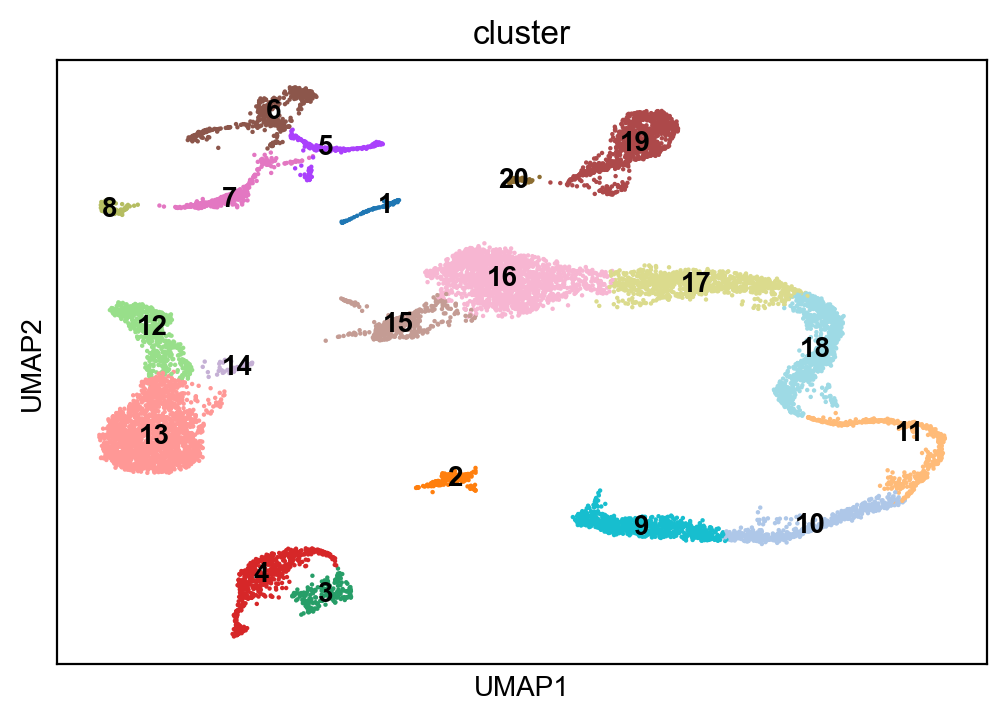

In [495]:
sc.pl.umap(agg, color="cluster", color_map="cividis_r", legend_loc="on data")

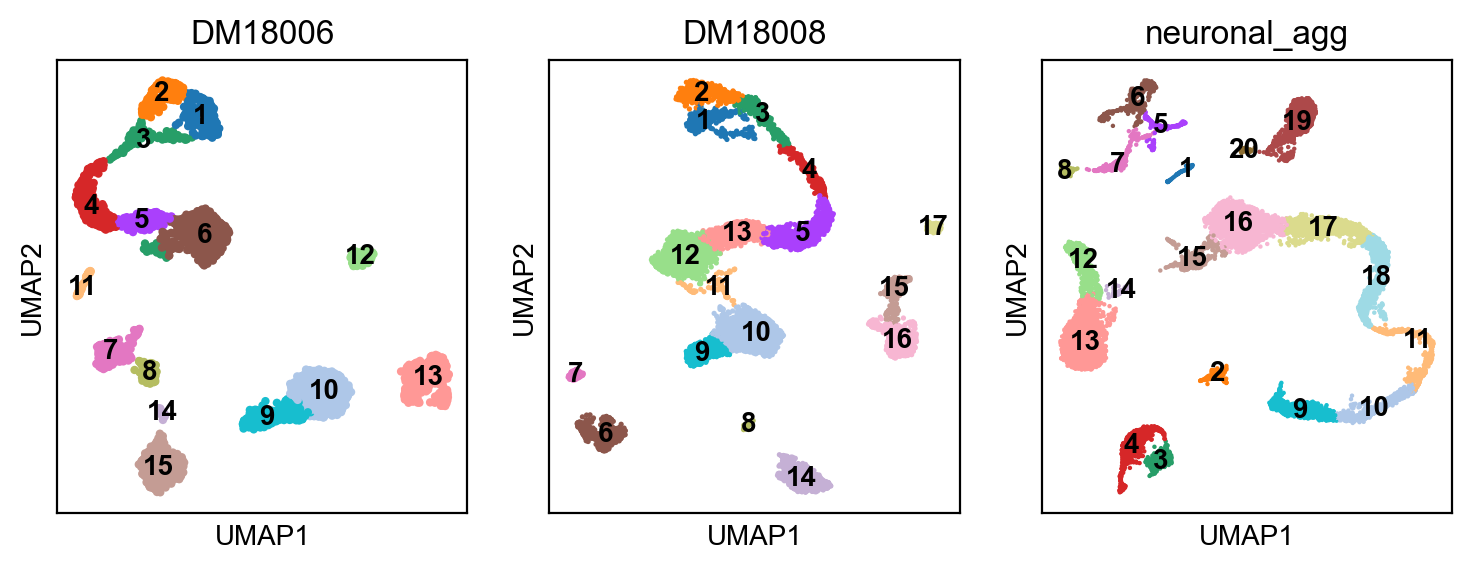

In [509]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for ax, ds in zip(axs.flat, (b6, con, agg)):
    sc.pl.umap(ds, color="cluster", ax=ax, legend_loc="on data", show=False, title=ds.uns["library_id"])

In [496]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
def classify(adata, n_classes, genes, name="global", cluster_key="leiden"):
    mixture = BayesianGaussianMixture(n_components=n_classes, random_state=0)
    X = adata[:, genes].X.toarray()
    
    mixture.fit(X)
    y = mixture.predict(X)
    
    k1 = f"classification_{name}_loglikelihood"
    adata.obs[k1] = 0
    for g, inds in adata.obs.groupby(cluster_key).groups.items():
        inds = adata.obs_names.isin(inds)
        score = mixture.score(X[inds, :])
        adata.obs.loc[inds, k1] = score
    int_key = f"classification_{name}_int"
    int_cluster_key = f"classification_{name}_cluster_int"
    adata.obs[int_key] = y
    adata.obs[int_cluster_key] = adata.obs.groupby(
        cluster_key
    )[int_key].transform(np.median).round().astype(int).astype("category")
    return mixture

In [497]:
neuronal_vs_nonneuronal_genes = ["Snap25", "Elavl2", "Syp", "Tubb3"]
inhibitory_vs_excitatory_genes = ["Slc32a1", "Slc17a6"]

In [498]:
classify(b6, 2, neuronal_vs_nonneuronal_genes)
classify(con, 2, neuronal_vs_nonneuronal_genes)
mix = classify(agg, 2, neuronal_vs_nonneuronal_genes)

In [500]:
mix.means_

array([[ 0.57019358,  1.26358756,  1.17091382,  0.52520203],
       [-0.18241408, -0.40283151, -0.37297611, -0.16755772]])

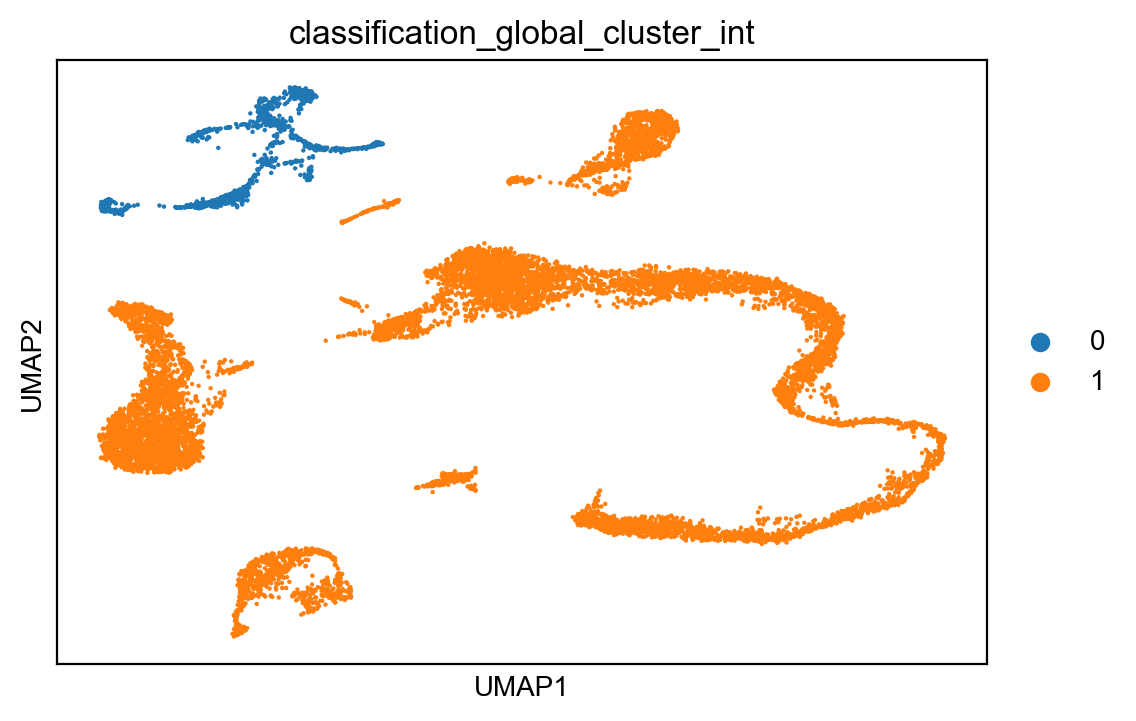

In [501]:
sc.pl.umap(agg, color="classification_global_cluster_int", color_map="Reds")

In [516]:
neuronal_bcs = agg.obs.classification_global_cluster_int == 0
neurons = agg[neuronal_bcs, :].copy()

In [522]:
nmix = classify(neurons, 3, inhibitory_vs_excitatory_genes, "neuronal")

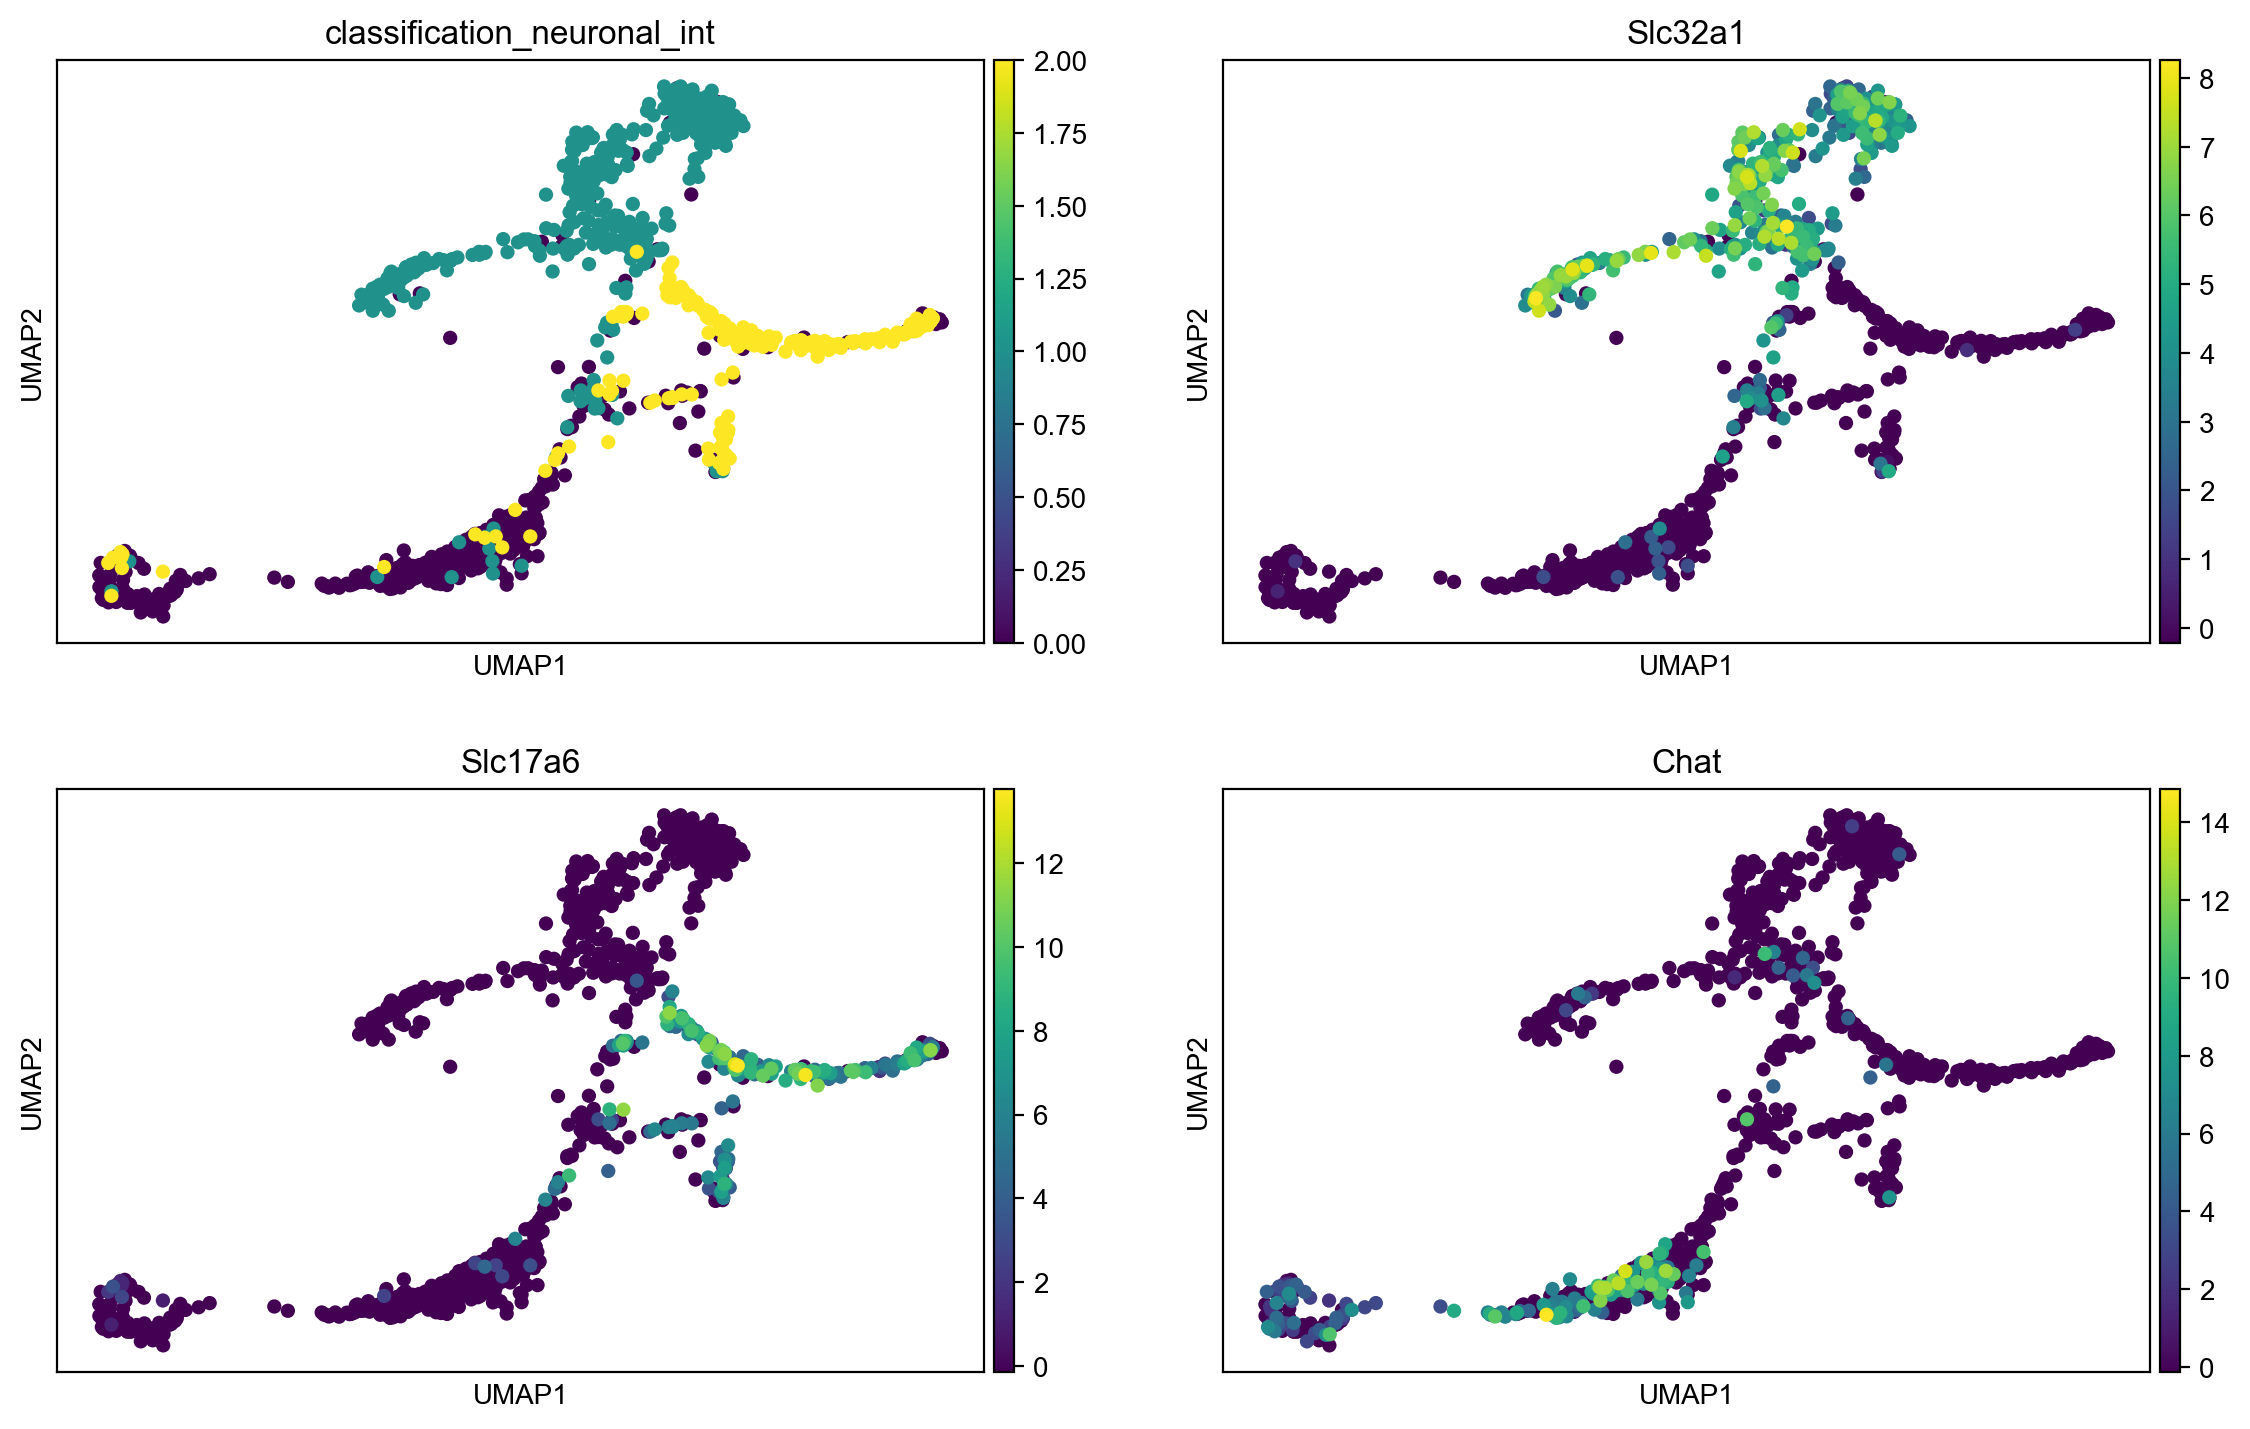

In [519]:
sc.pl.umap(neurons, color=["classification_neuronal_int", "Slc32a1", "Slc17a6", "Chat"], ncols=2)

In [567]:
a, b = nmix.sample(10000)

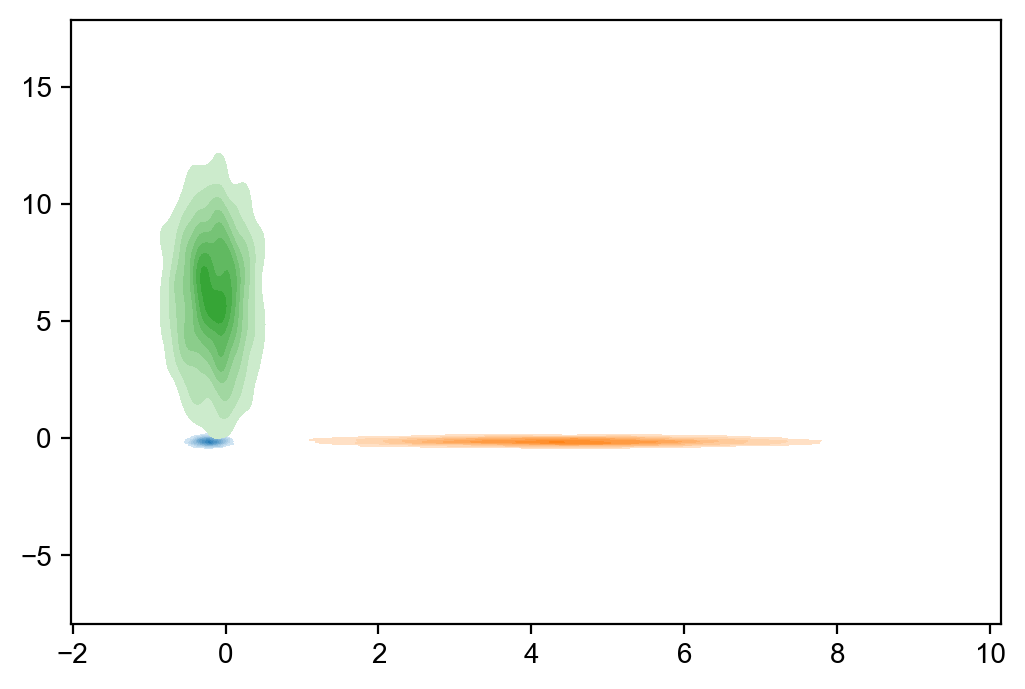

In [579]:
sns.kdeplot(a[b==0], shade=True, shade_lowest=False)
sns.kdeplot(a[b==1], shade=True, shade_lowest=False)
sns.kdeplot(a[b==2], shade=True, shade_lowest=False)

Text(1, 0.7, 'Slc32a1')

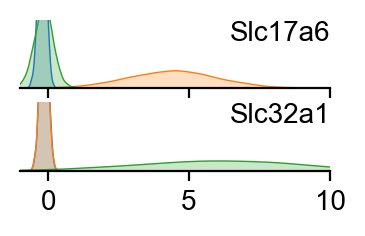

In [575]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(2, 1), sharex=True)
for k in range(3):
    sns.kdeplot(a[b==k,0], shade=True, lw=0.5, cut=0, ax=ax1)
    sns.kdeplot(a[b==k,1], shade=True, lw=0.5, cut=0, ax=ax2)
sns.despine(fig, left=True)
for ax in (ax1, ax2):
    ax.set_yticks([])
    ax.set_xlim(-1, 10)
    ax.set_ylim(0, 1)
ax1.text(1, 0.7, "Slc17a6", ha="right", transform=ax1.transAxes)
ax2.text(1, 0.7, "Slc32a1", ha="right", transform=ax2.transAxes)

In [520]:
agg.obs["classification_neuronal_int"] = -1
agg.obs["classification_neuronal_cluster_int"] = -1
agg.obs.loc[neuronal_bcs, "classification_neuronal_int"] = neurons.obs.classification_neuronal_int
agg.obs.loc[neuronal_bcs, "classification_neuronal_cluster_int"] = neurons.obs.classification_neuronal_cluster_int

... storing 'classification_neuronal_cluster_int' as categorical


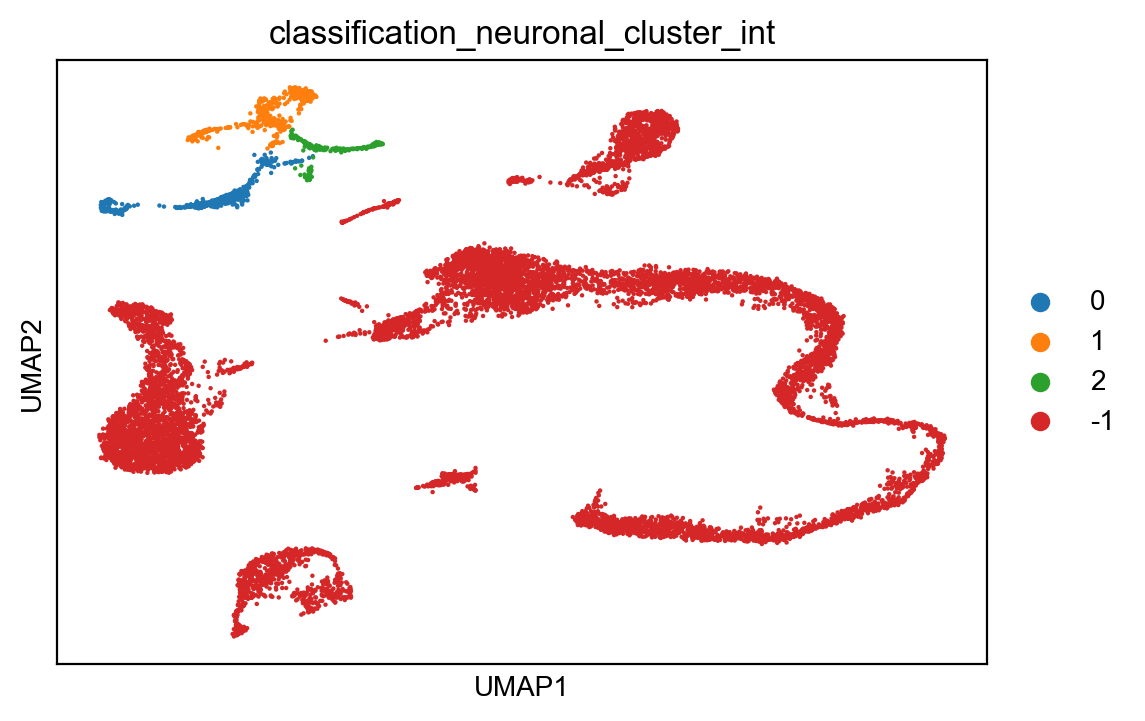

In [521]:
sc.pl.umap(agg, color="classification_neuronal_cluster_int")

In [526]:
save_adata(agg, "clustered")

In [581]:
slc17a6_bcs = neurons.obs_names[neurons.obs.classification_neuronal_cluster_int == 2]
slc32a1_bcs = neurons.obs_names[neurons.obs.classification_neuronal_cluster_int == 1]

In [641]:
slc17a6_raw = merged[slc17a6_bcs, :].copy()
slc32a1_raw = merged[slc32a1_bcs, :].copy()

In [648]:
slc17a6 = pipeline(
    slc17a6_raw, n_top_genes=1000, n_pcs=25,
    min_dist=0.5, neighbors=15, resolution=0.4,
    remove_doublets=False
)
slc32a1 = pipeline(
    slc32a1_raw, n_top_genes=1000, n_pcs=25,
    min_dist=0.5, neighbors=15, resolution=0.4,
    remove_doublets=False
)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 25
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float

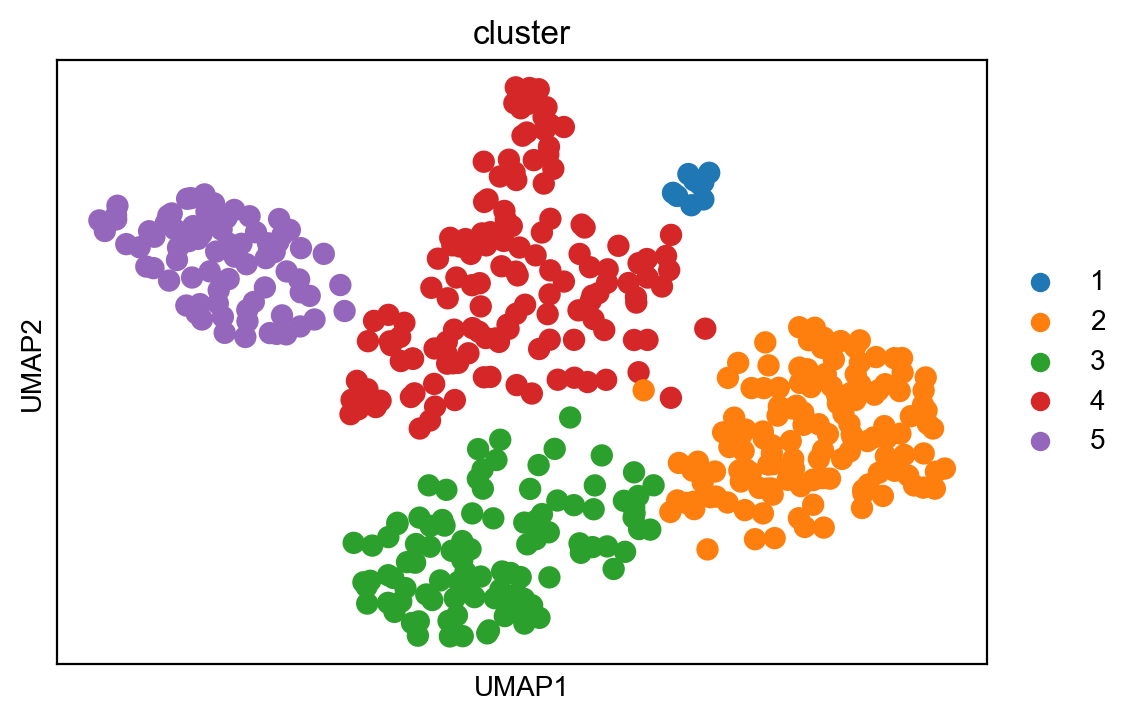

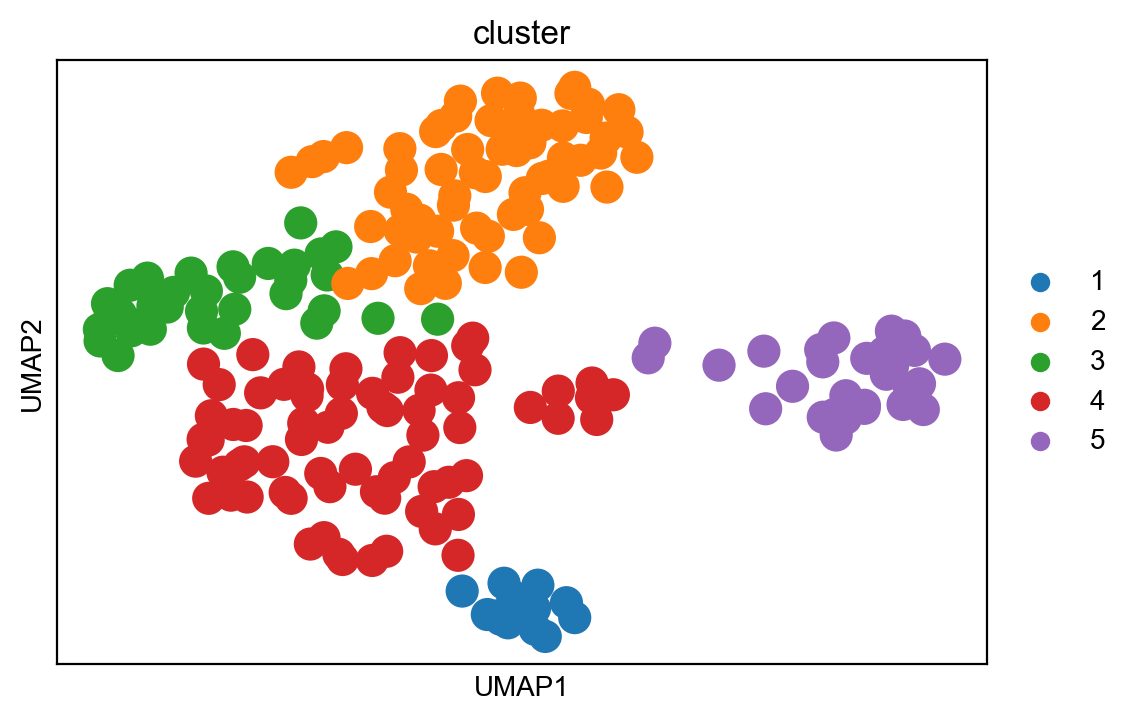

In [649]:
sc.pl.umap(slc32a1, color="cluster")
sc.pl.umap(slc17a6, color="cluster")

In [650]:
save_adata(slc17a6, "slc17a6")
save_adata(slc32a1, "slc32a1")

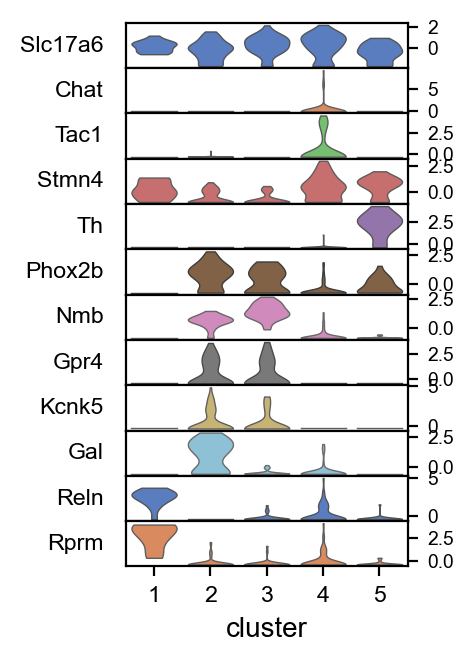

In [635]:
sc.pl.stacked_violin(slc17a6, slc17a6_markers, groupby="cluster", swap_axes=True, cut=0)

In [630]:
sc.tl.rank_genes_groups(slc17a6, groupby="cluster")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cluster']`


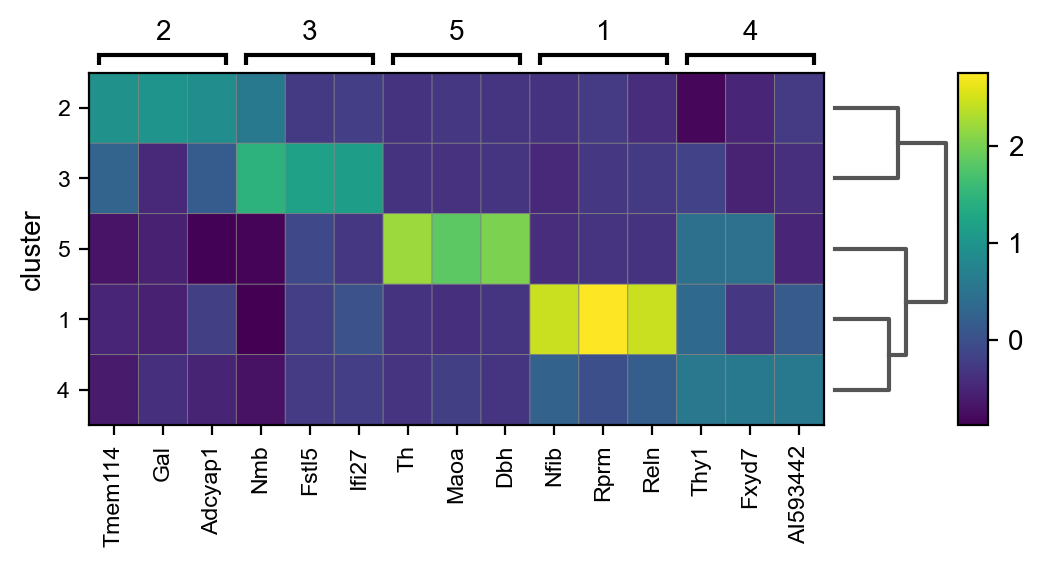

In [631]:
sc.pl.rank_genes_groups_matrixplot(slc17a6, n_genes=3, groupby="cluster")

In [ ]:
sc.pl.rank_genes_groups_matrixplot(slc17a6, n_genes=3, groupby="cluster")

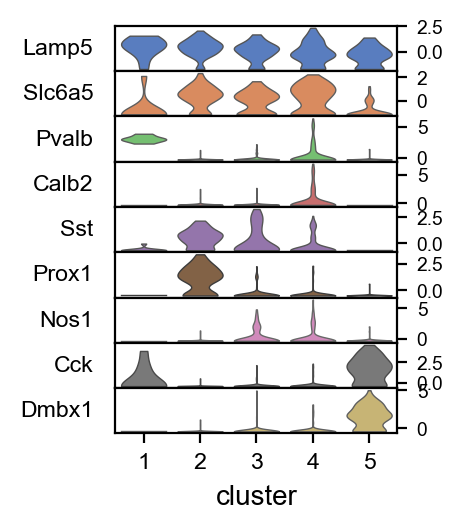

In [636]:
sc.pl.stacked_violin(slc32a1, slc32a1_markers, groupby="cluster", swap_axes=True)

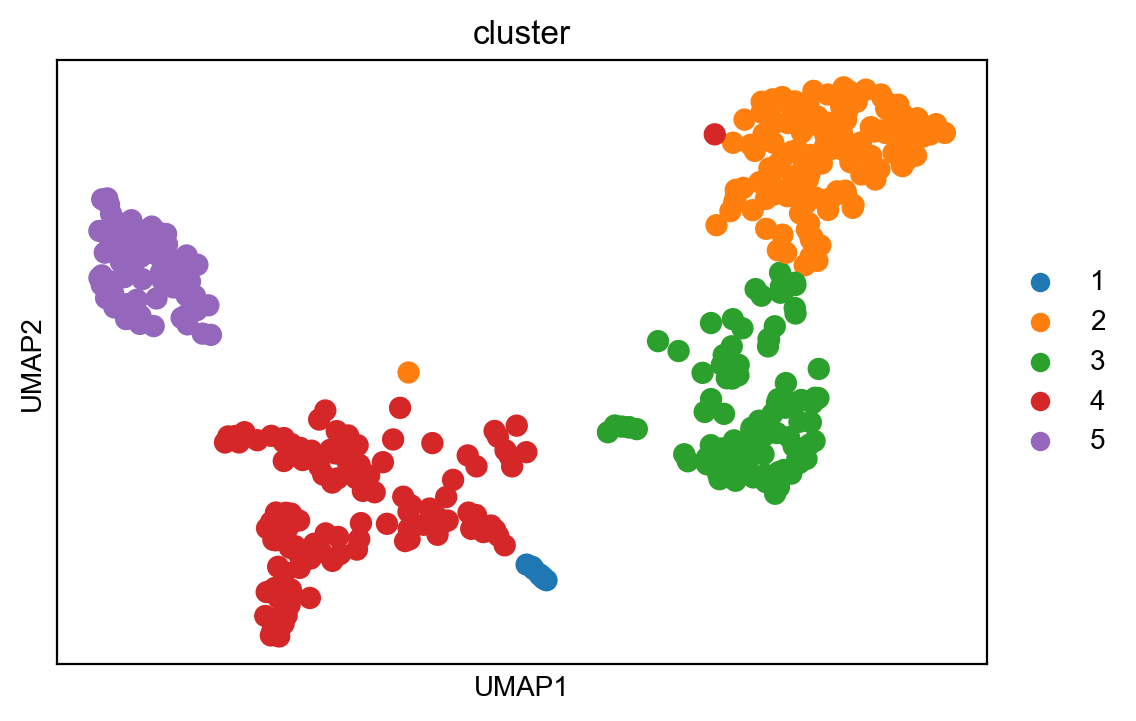

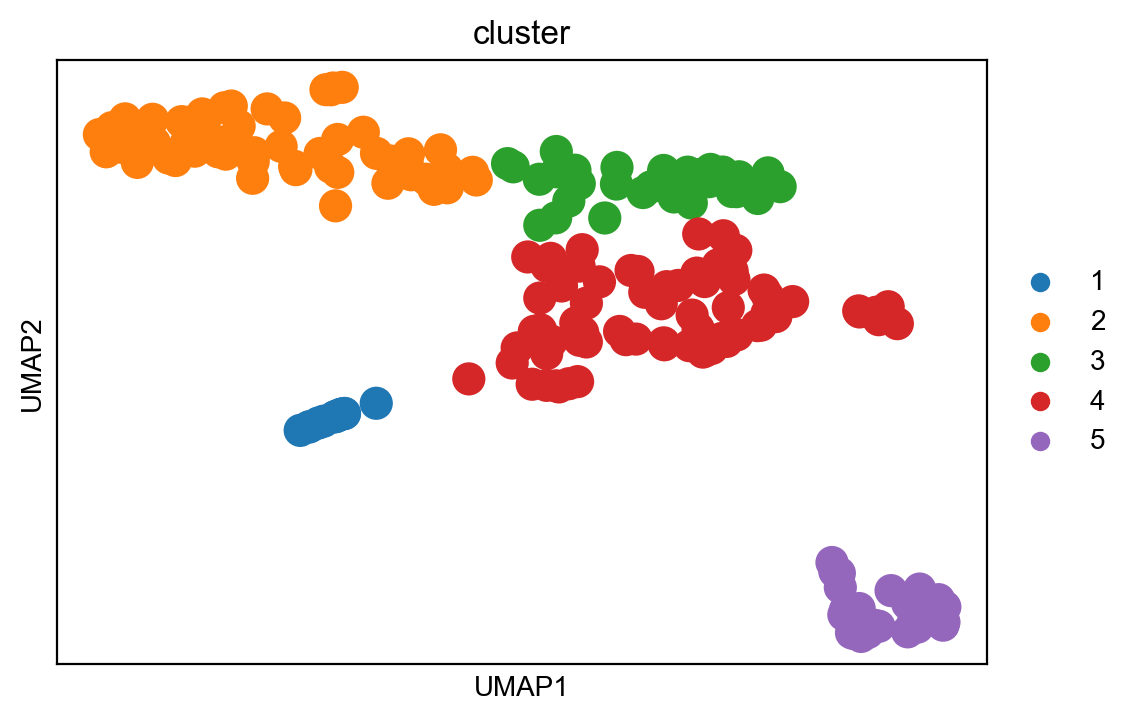

In [646]:
sc.pl.umap(slc32a1, color="cluster")
sc.pl.umap(slc17a6, color="cluster")

In [625]:
slc17a6_markers = "Slc17a6 Chat Tac1 Stmn4 Th Phox2b Nmb Gpr4 Kcnk5 Gal Reln Rprm".split()
slc32a1_markers = "Lamp5 Slc6a5 Pvalb Calb2 Sst Prox1 Nos1 Cck Dmbx1".split()

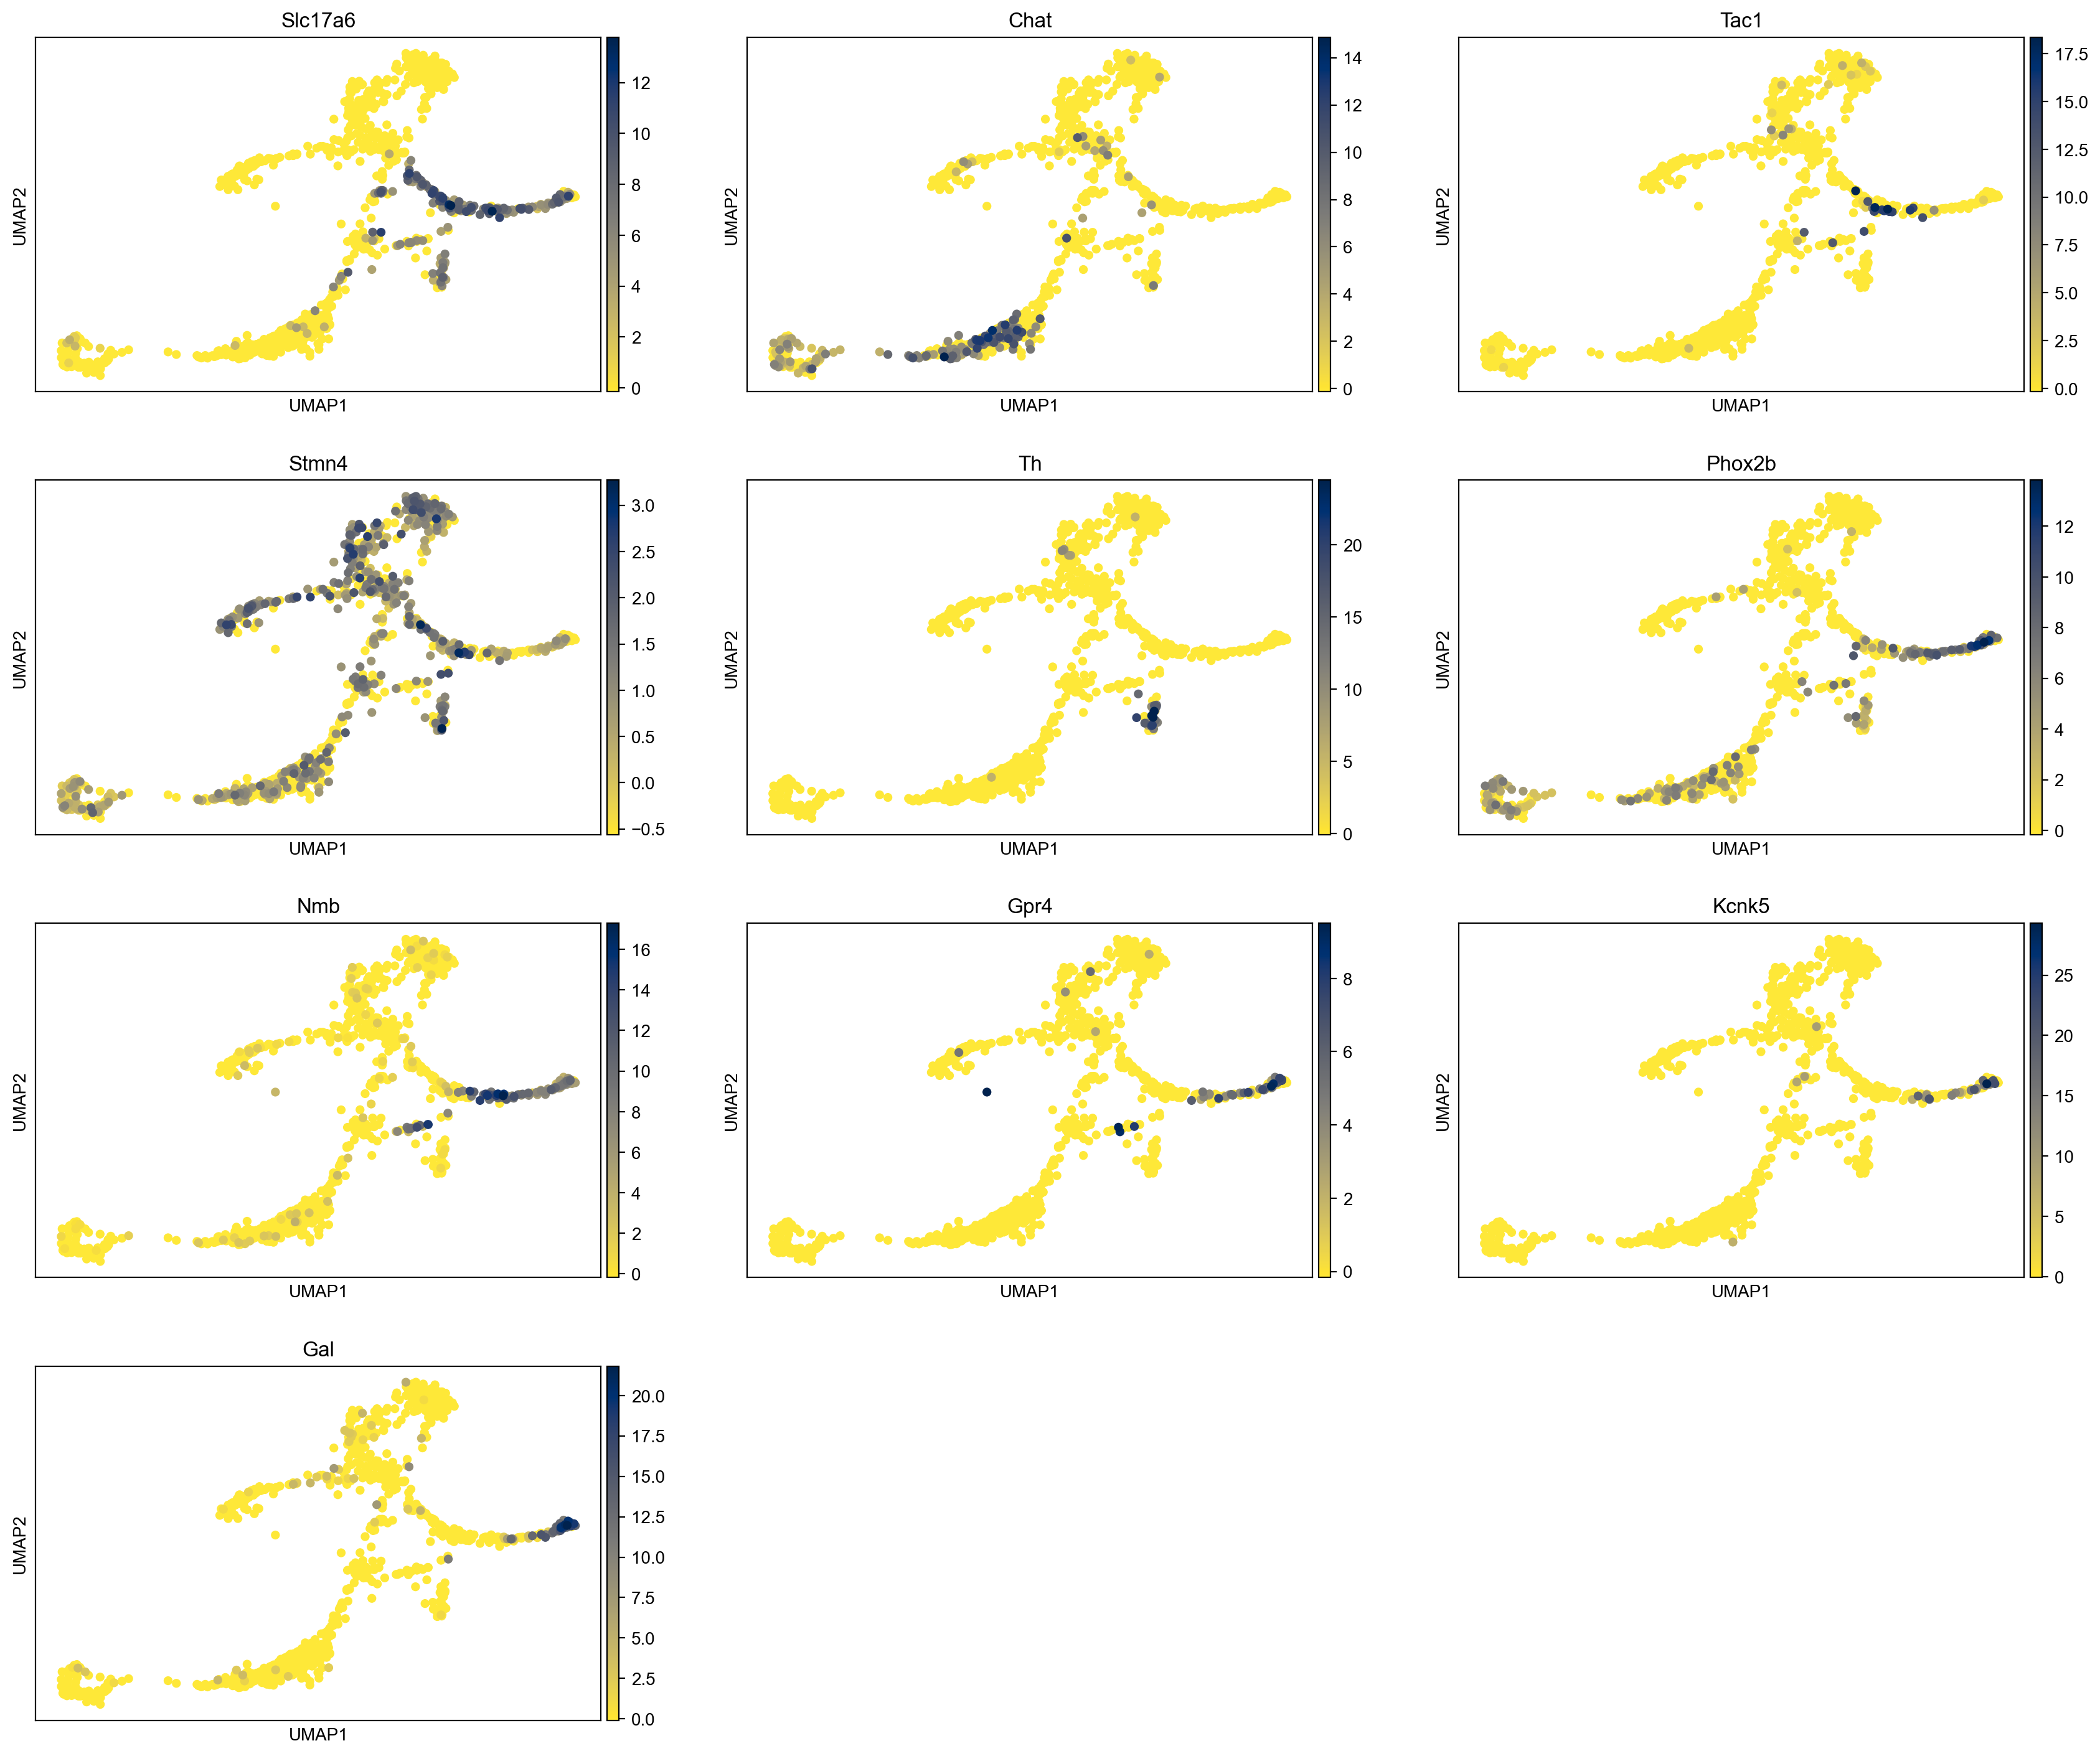

In [515]:
sc.pl.umap(neurons, color=slc17a6_markers, color_map="cividis_r", ncols=3)

In [651]:
sc.tl.rank_genes_groups(slc32a1, groupby="cluster")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


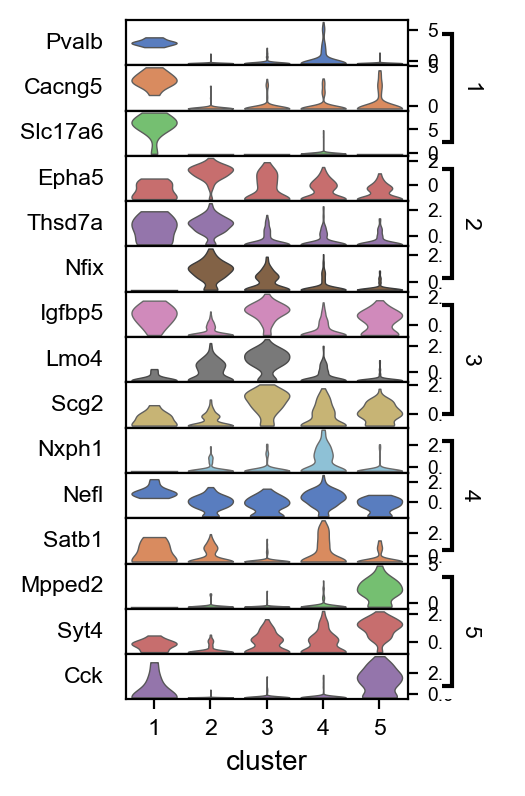

In [656]:
sc.pl.rank_genes_groups_stacked_violin(slc32a1, groupby="cluster", n_genes=3, swap_axes=True, dendrogram=False)

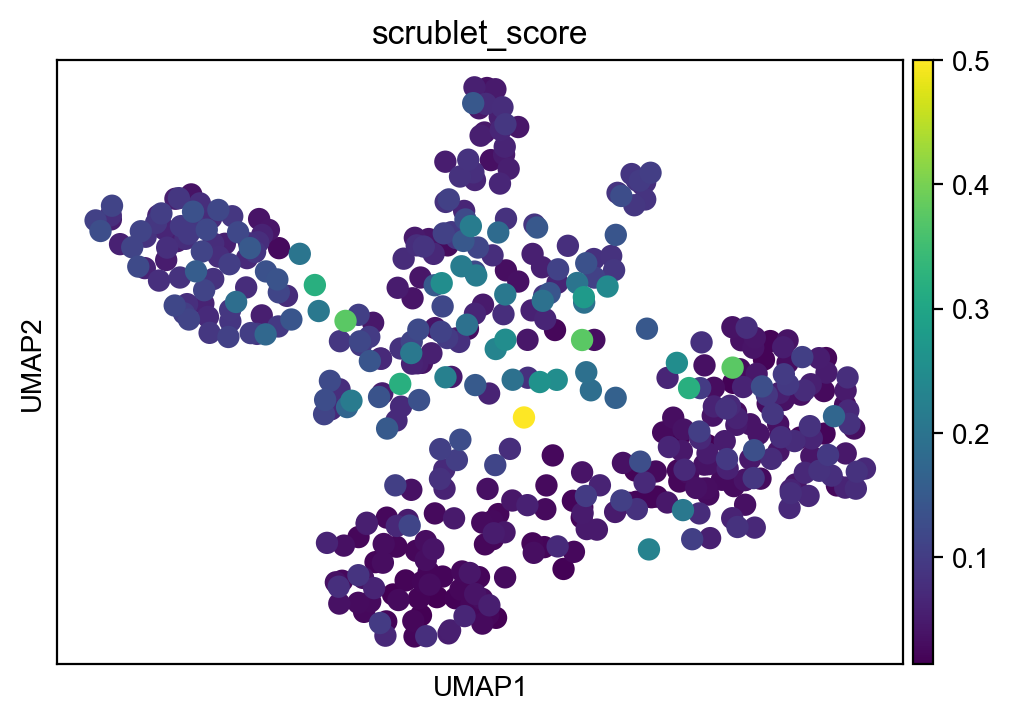

In [657]:
sc.pl.umap(slc32a1, color="scrublet_score")

In [673]:
slc32a1_redo = slc32a1_raw[~np.asarray((slc32a1_raw[:, "Slc17a6"].X > 0).todense()).ravel(), :].copy()

In [674]:
slc32a1_redo = pipeline(
    slc32a1_redo, n_top_genes=1000, n_pcs=25,
    min_dist=0.5, neighbors=15, resolution=0.5,
    remove_doublets=False
)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 25
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [677]:
sc.tl.rank_genes_groups(slc32a1_redo, groupby="cluster")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


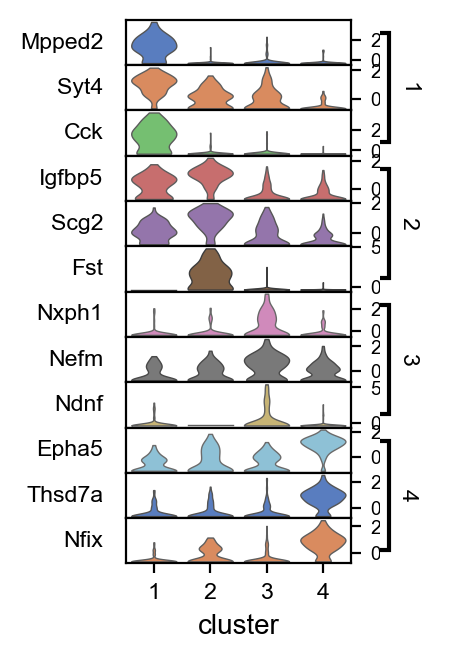

In [678]:
sc.pl.rank_genes_groups_stacked_violin(slc32a1_redo, groupby="cluster", n_genes=3, swap_axes=True, dendrogram=False)

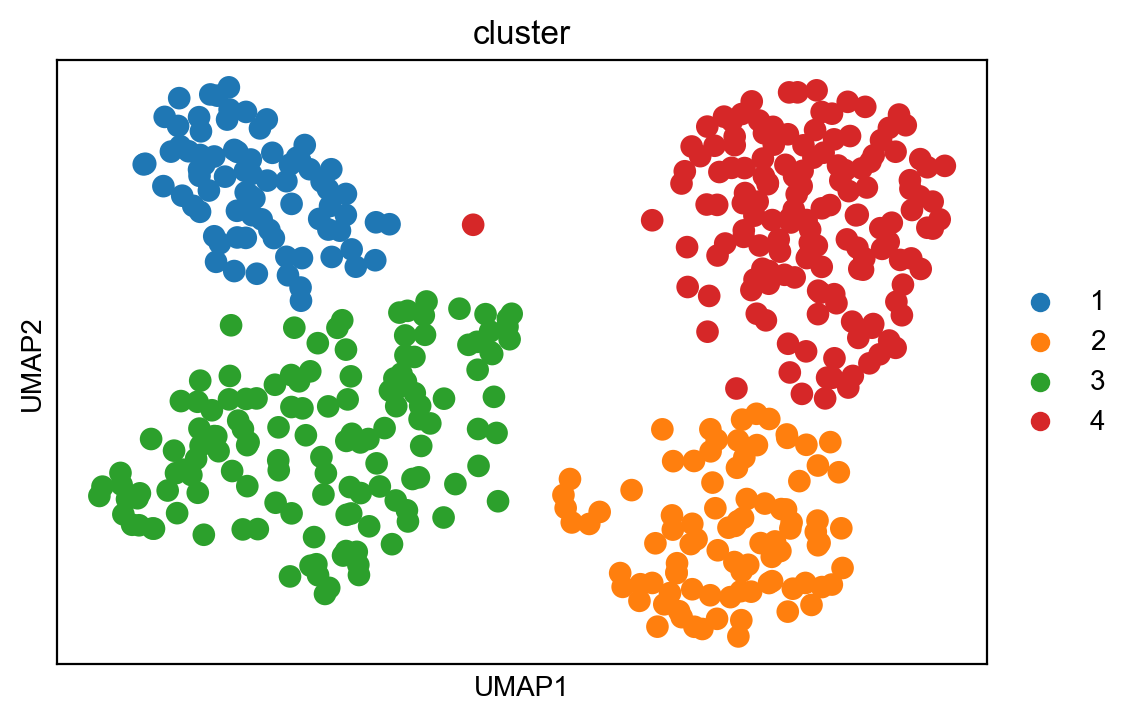

In [675]:
sc.pl.umap(slc32a1_redo, color="cluster")

In [676]:
save_adata(slc32a1_redo, "slc32a1-nodub")

In [682]:
def save_for_loupe(adata, subdir=""):
    final_barcodes = adata.obs_names
    loupe_barcodes = final_barcodes.str.extract("([ACGT]+)", expand=True)
    loupe_barcodes["num"] = final_barcodes.str.extract("[ACGT]+-\d+-(\d+)", expand=False)
    loupe_barcodes["num"] = (loupe_barcodes["num"].astype(int) + 1).astype(str)
    loupe_barcodes = pd.DataFrame(loupe_barcodes.iloc[:,0] + "-" + loupe_barcodes.iloc[:,1], columns=["Barcode"])
    cloupe_umap = pd.DataFrame(
        adata.obsm["X_umap"],
        index=loupe_barcodes.Barcode.values,
        columns=["x coordinate", "y coordinate"]
    )
    cloupe_umap.index.name = "barcode"

    _data = {
        "Custom Cluster": "Cluster " + adata.obs["cluster"].str.zfill(2).values,
    }
    cloupe_metadata = pd.DataFrame(
        _data,
        index=loupe_barcodes.Barcode.values
    )
    cloupe_metadata.index.name = "barcode"


    outpath = Path(f"/projects/robson-lab/research/brain-stem_rtn/analysis/neurons/loupe/{subdir}")
    if not outpath.exists():
        outpath.mkdir(parents=True, exist_ok=True)

    loupe_barcodes.to_csv(outpath / "loupe_barcodes.csv", index=False)
    cloupe_metadata.to_csv(outpath / "loupe_metadata.csv")
    cloupe_umap.to_csv(outpath / "loupe_umap.csv")

In [ ]:
save_for_loupe(slc17a6, "slc17a6")
save_for_loupe(slc17a6, "slc17a6")